Data Loading & Preprocessing

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Load data
df = pd.read_csv('processed_bookmarks.csv')

# Combine text features with NaN handling
df['full_text'] = df['clean_title'].fillna('') + ' ' + df['clean_description'].fillna('')

# Verify there are no missing values
print("Missing values in full_text:", df['full_text'].isna().sum())

# Encode labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['new_category'])

# Check for missing labels
print("Missing labels:", df['label'].isna().sum())

# Split data (ensure stratify works)
X_train, X_test, y_train, y_test = train_test_split(
    df['full_text'], 
    df['label'], 
    test_size=0.2, 
    random_state=42, 
    stratify=df['label']
)

# TF-IDF Vectorization with additional checks
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2),
    min_df=2,  # Add minimum document frequency
    max_df=0.95
)

# Verify training data
print("\nSample training texts:")
print(X_train.head())
print("\nData types:", X_train.apply(type).value_counts())

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Save preprocessing artifacts
joblib.dump(tfidf, 'tfidf_vectorizer.joblib')
joblib.dump(le, 'label_encoder.joblib')

Missing values in full_text: 0
Missing labels: 0

Sample training texts:
16562    drunk minecraft 58 goku s nipples this episode...
6164     bbc ukraine editor on her surreal escape from ...
7152     amazing new podcast on neuroscience from andre...
4323     dmt is the most powerful psychedelic matthew j...
17184    children sheltering from russian bombs in ukra...
Name: full_text, dtype: object

Data types: full_text
<class 'str'>    14725
Name: count, dtype: int64


['label_encoder.joblib']

In [2]:
# Common function to plot confusion matrices
def plot_confusion_matrix(y_true, y_pred, class_names, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

Accuracy: 0.9592612710483432
                       precision    recall  f1-score   support

     Autos & Vehicles       0.99      0.99      0.99       234
Entertainment & Media       0.99      0.96      0.97      1021
        Howto & Style       0.92      0.99      0.96       386
     Lifestyle & Pets       0.91      0.81      0.86       206
      News & Politics       0.92      0.98      0.95       702
   Science & Learning       0.98      0.95      0.97       808
               Sports       1.00      0.96      0.98       244
  Travel & Adventures       0.89      0.96      0.92        81

             accuracy                           0.96      3682
            macro avg       0.95      0.95      0.95      3682
         weighted avg       0.96      0.96      0.96      3682



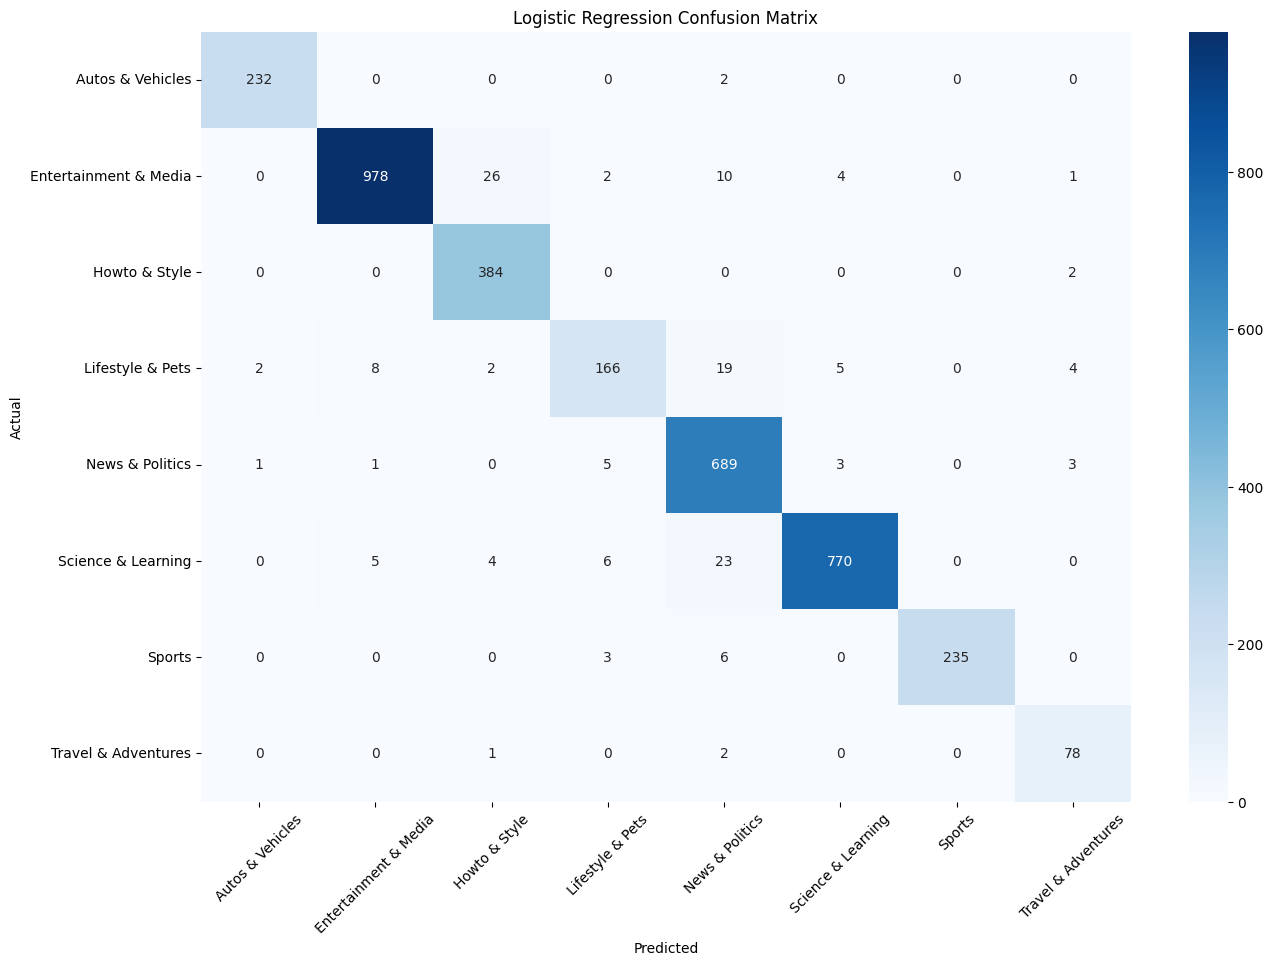

['logistic_regression.joblib']

In [3]:
from sklearn.linear_model import LogisticRegression

# Train
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train_tfidf, y_train)

# Evaluate
y_pred = lr.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
plt.figure(figsize=(15,10))
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, 
            yticklabels=le.classes_)
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.show()

# Save model
joblib.dump(lr, 'logistic_regression.joblib')

Random Forest Results:
Accuracy: 0.965507876154264
                       precision    recall  f1-score   support

     Autos & Vehicles       0.98      0.98      0.98       234
Entertainment & Media       0.98      0.97      0.98      1021
        Howto & Style       0.96      1.00      0.98       386
     Lifestyle & Pets       0.99      0.79      0.88       206
      News & Politics       0.92      0.99      0.95       702
   Science & Learning       0.98      0.96      0.97       808
               Sports       1.00      0.96      0.98       244
  Travel & Adventures       0.92      0.95      0.93        81

             accuracy                           0.97      3682
            macro avg       0.97      0.95      0.96      3682
         weighted avg       0.97      0.97      0.97      3682



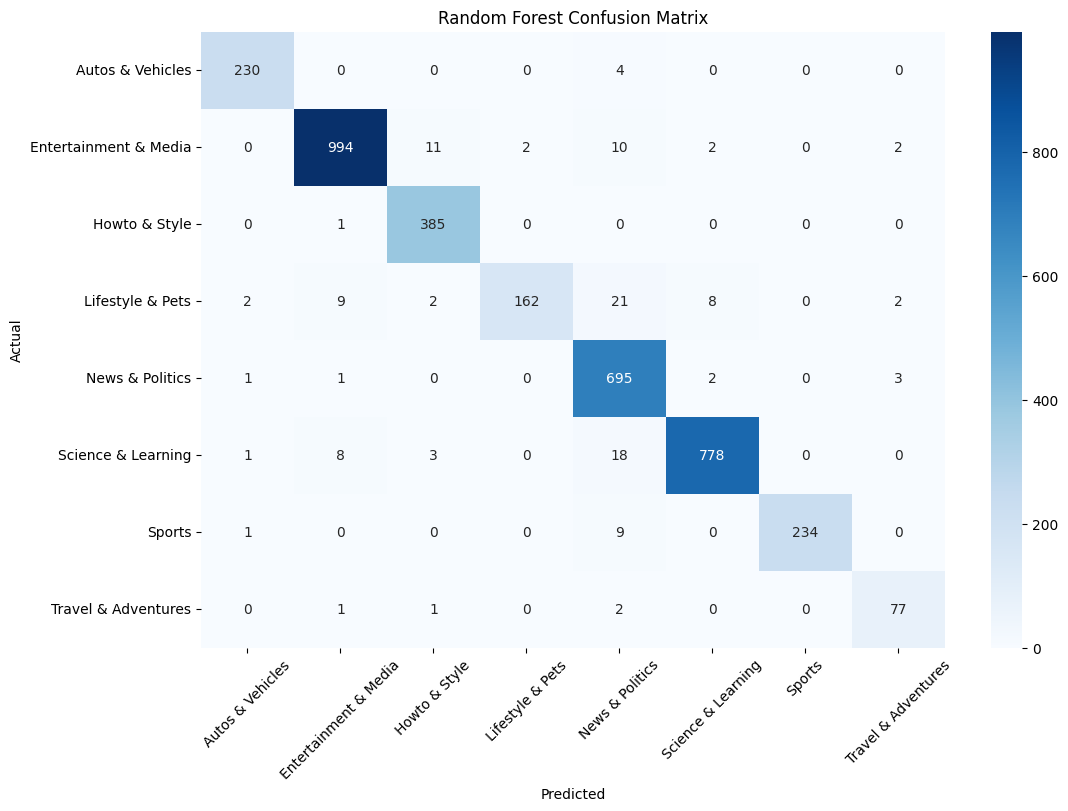

In [27]:
from sklearn.ensemble import RandomForestClassifier

# Train
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced')
rf.fit(X_train_tfidf, y_train)
y_pred_rf = rf.predict(X_test_tfidf)

print("Random Forest Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

# RF Confusion Matrix
plot_confusion_matrix(y_test, y_pred_rf, le.classes_, 
                     "Random Forest Confusion Matrix")



XGBoost Results:
Accuracy: 0.9690385659967409
                       precision    recall  f1-score   support

     Autos & Vehicles       0.99      0.99      0.99       234
Entertainment & Media       0.98      0.98      0.98      1021
        Howto & Style       0.97      0.99      0.98       386
     Lifestyle & Pets       0.95      0.82      0.88       206
      News & Politics       0.93      0.98      0.95       702
   Science & Learning       0.98      0.97      0.98       808
               Sports       1.00      0.96      0.98       244
  Travel & Adventures       0.96      0.95      0.96        81

             accuracy                           0.97      3682
            macro avg       0.97      0.96      0.96      3682
         weighted avg       0.97      0.97      0.97      3682



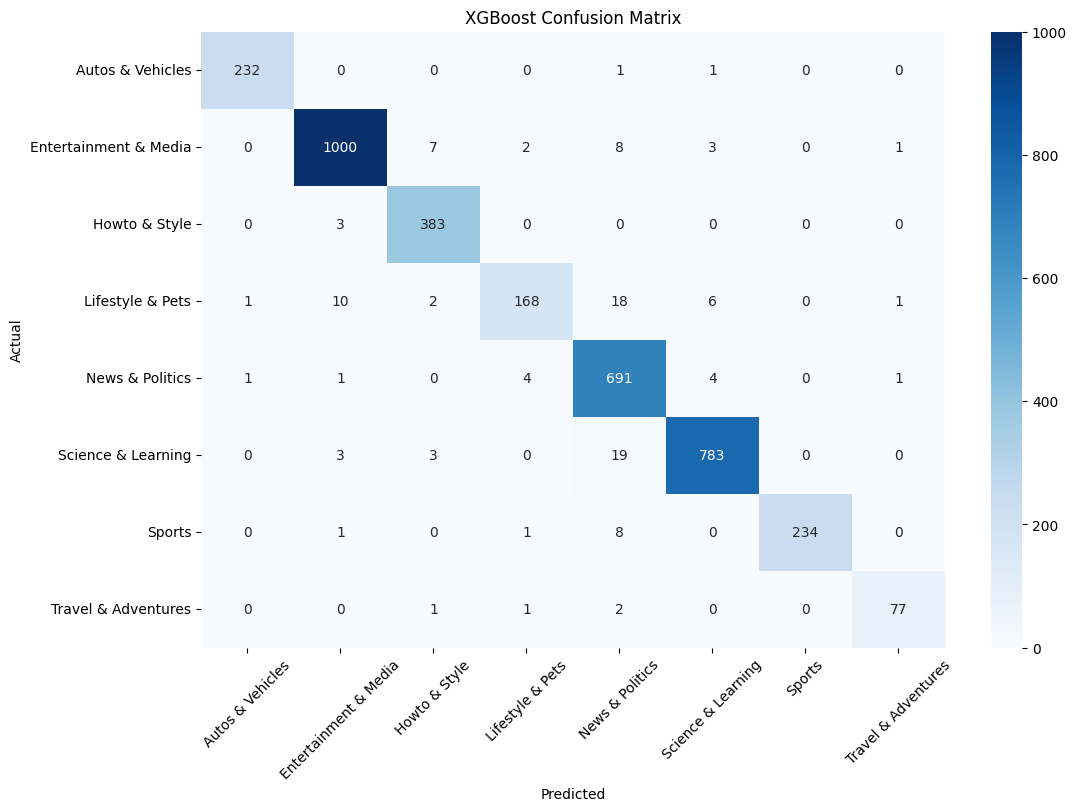

['xgboost_model.joblib']

In [4]:
from xgboost import XGBClassifier

# Train
xgb = XGBClassifier(tree_method='hist')
xgb.fit(X_train_tfidf, y_train)
y_pred_xgb = xgb.predict(X_test_tfidf)

print("\nXGBoost Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb, target_names=le.classes_))

# XGB Confusion Matrix
plot_confusion_matrix(y_test, y_pred_xgb, le.classes_, 
                     "XGBoost Confusion Matrix")

joblib.dump(xgb, 'xgboost_model.joblib')

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.4502 - loss: 2.4266 - val_accuracy: 0.0702 - val_loss: 2.5591 - learning_rate: 5.0000e-04
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8877 - loss: 1.1113 - val_accuracy: 0.3658 - val_loss: 2.1661 - learning_rate: 5.0000e-04
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9283 - loss: 0.9175 - val_accuracy: 0.8266 - val_loss: 1.5684 - learning_rate: 5.0000e-04
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9481 - loss: 0.8103 - val_accuracy: 0.9402 - val_loss: 1.0528 - learning_rate: 5.0000e-04
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9601 - loss: 0.7291 - val_accuracy: 0.9574 - val_loss: 0.7573 - learning_rate: 5.0000e-04
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.9688 - loss: 0.6521 - val_accuracy: 0.9597 - val_loss: 0.6444 - learning_rate: 5.0000e-04
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9714

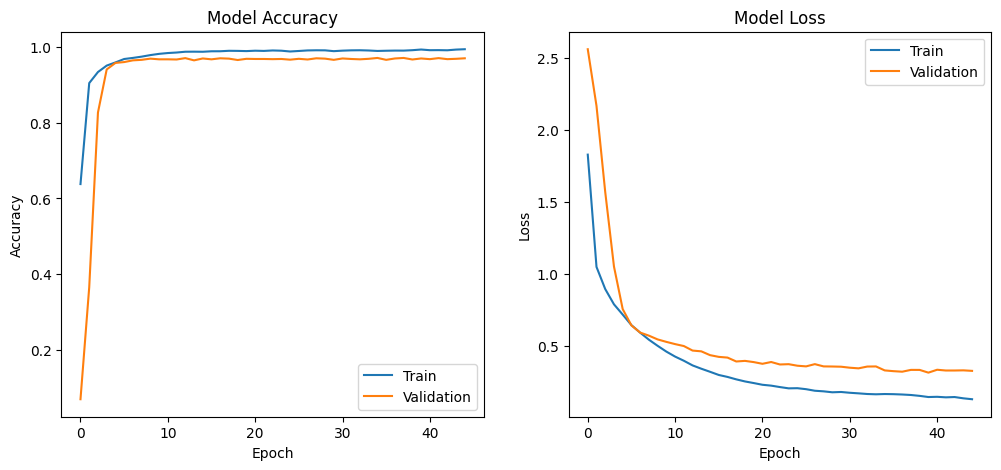

116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Neural Network Results:
Accuracy: 0.9633351439435089
                       precision    recall  f1-score   support

     Autos & Vehicles       0.99      0.99      0.99       234
Entertainment & Media       0.99      0.97      0.98      1021
        Howto & Style       0.95      0.99      0.97       386
     Lifestyle & Pets       0.93      0.81      0.87       206
      News & Politics       0.93      0.97      0.95       702
   Science & Learning       0.97      0.97      0.97       808
               Sports       1.00      0.96      0.98       244
  Travel & Adventures       0.93      0.95      0.94        81

             accuracy                           0.96      3682
            macro avg       0.96      0.95      0.95      3682
         weighted avg       0.96      0.96      0.96      3682



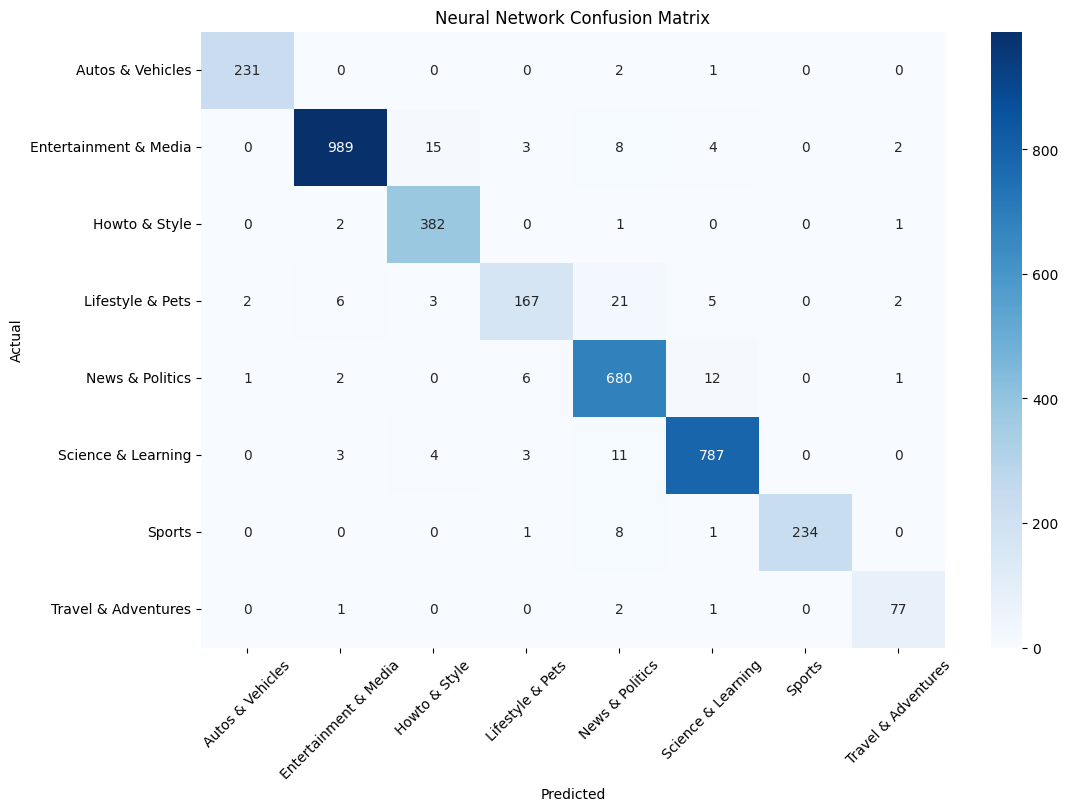

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Enhanced model architecture
model = Sequential([
    Dense(256, activation='relu', 
          input_shape=(X_train_tfidf.shape[1],),
          kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.6),
    
    Dense(128, activation='relu',
          kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(64, activation='relu',
          kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(len(le.classes_), activation='softmax')
])

# Custom optimizer configuration
optimizer = Adam(
    learning_rate=0.0005,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07
)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks for better training control
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

# Enhanced training with larger batch size
history = model.fit(
    X_train_tfidf.toarray(), y_train,
    epochs=50,  # Allowing more epochs with early stopping
    batch_size=128,
    validation_split=0.15,  # Slightly larger validation split
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Plot training history
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Evaluate
y_pred = model.predict(X_test_tfidf.toarray()).argmax(axis=1)
print("\nNeural Network Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

# NN Confusion Matrix
plot_confusion_matrix(y_test, y_pred, le.classes_,
                     "Neural Network Confusion Matrix")

# Save model
model.save('nn_model.h5')

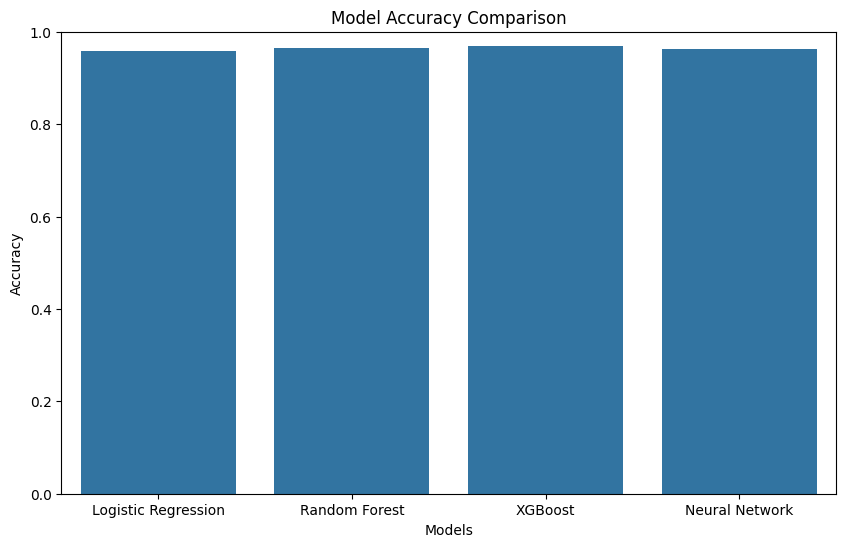

In [31]:
# Accuracy comparison plot
models = ['Logistic Regression', 'Random Forest', 'XGBoost', 'Neural Network']
accuracies = [accuracy_score(y_test, lr.predict(X_test_tfidf)),
              accuracy_score(y_test, rf.predict(X_test_tfidf)),
              accuracy_score(y_test, xgb.predict(X_test_tfidf)),
              accuracy_score(y_test, y_pred)]

plt.figure(figsize=(10,6))
sns.barplot(x=models, y=accuracies)
plt.ylim(0,1)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Models')
plt.show()